In [42]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import skimage

import pybinding as pb
from pybinding.repository import graphene

import os

from tqdm import tqdm

### Importing Data

In [43]:
%matplotlib inline

In [44]:
!mkdir freqout

mkdir: cannot create directory ‘freqout’: File exists


In [45]:
fpath = r"Calculations/graphene_gauss_0d2_sublatticeA/continous_ldos.csv"
df=pd.read_csv(fpath)
df.head()

,Unnamed: 0,x,y,Re(z),Im(z)
0,0,-20.00000,-20.0,0.003596,0.0
1,1,-19.95996,-20.0,0.004863,0.0
2,2,-19.91992,-20.0,0.005855,0.0
3,3,-19.87988,-20.0,0.006424,0.0
4,4,-19.83984,-20.0,0.006622,0.0


In [46]:
# Get the sample name to use on graphs from directory
dir_path = os.path.dirname(fpath)
sample_name = os.path.basename(dir_path)
print(sample_name)

graphene_gauss_0d2_sublatticeA


In [47]:
w = int(np.sqrt(np.size(df['x'])))

x = np.reshape(df['x'], (w, w))
y = np.reshape(df['y'], (w, w))
z = np.reshape(df['Re(z)'] + 1j * df['Im(z)'], (w, w)).astype(np.complex128)

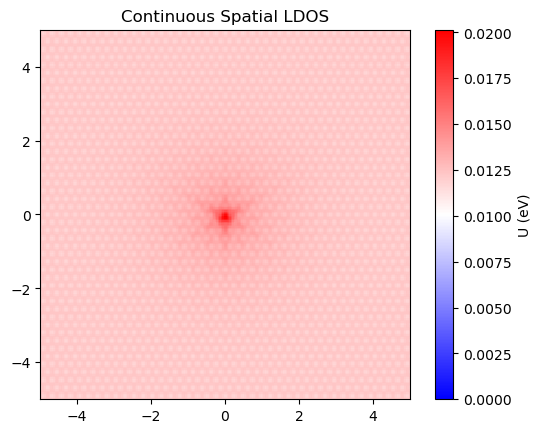

In [49]:
fig3, ax3 = plt.subplots()

z_min, z_max = 0, np.abs(z).max()

c = ax3.pcolormesh(x, y, np.abs(z), cmap='bwr', vmin=z_min, vmax=z_max)
ax3.axis([x.min(), x.max(), y.min(), y.max()])
fig3.colorbar(c, ax=ax3, label="U (eV)")
ax3.set_aspect("equal")
ax3.set_xlim(-5, 5)
ax3.set_ylim(-5, 5)

ax3.set_title("Continuous Spatial LDOS")
fig3.savefig("output/continuous_ldos.png")

### FFT and Filtering

Text(0.5, 1.0, '2D FFT: graphene_gauss_0d2_sublatticeA')

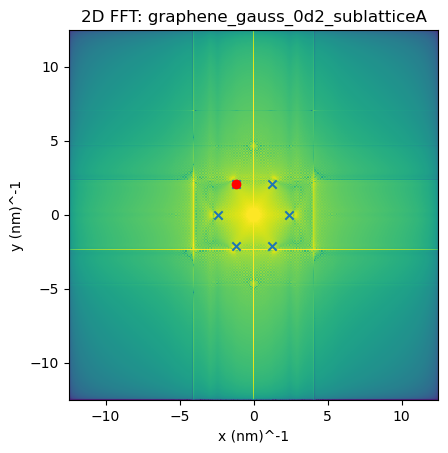

In [53]:
# FFT
ftz = np.fft.fft2(z)
ftz = np.fft.fftshift(ftz) # Shifts zero component freq to center

# Log scale
plz = np.log(np.abs(ftz ** 2))

# Generate Frequency Axis
# From tbinding_ldos
# x, y where generated from x = np.linspace(-size, size, mesh_size)
# In this example x = np.linspace(-20, 20, 1000)

l = np.linspace(-20, 20, 1000)

stepl = l[1] - l[0]
fx = np.fft.fftfreq(len(l), stepl)
fy = np.fft.fftfreq(len(l), stepl)
fxs = np.fft.fftshift(fx)
fys = np.fft.fftshift(fy)

# Plotting analytic K valleys ontop
#kx = [ 8.51553203,-8.51553203,0]
#ky = [ 4.91644471, 4.91644471, -9.83288942]
#kpx = [ 8.51553203,-8.51553203,0]
#kpy = [-4.91644471,-4.91644471,9.83288942]

# From Bena 2008
acc=0.142 #nm
Kx = 1 * np.array([4*np.pi/(3*np.sqrt(3)), -4*np.pi/(3*np.sqrt(3)), 2 * np.pi/(3 * np.sqrt(3)), -2 * np.pi/(3 * np.sqrt(3)), 2 * np.pi/(3 * np.sqrt(3)), -2 * np.pi/(3 * np.sqrt(3))])
Ky = 1 * np.array([0, 0, 2*np.pi/3, 2*np.pi/3, -2*np.pi/3, -2*np.pi/3])


#difference
dpx = Kx[2] - Kx[0]
dpy = Ky[2] - Ky[0]

fig4, ax4 = plt.subplots()
ax4.pcolormesh(fxs, fys, plz, vmax=np.mean(plz)/100)

ax4.scatter(Kx, Ky, marker="x")
ax4.scatter(dpx, dpy, marker='o', color='red')

ax4.set_xlabel("x (nm)^-1")
ax4.set_ylabel("y (nm)^-1")
ax4.set_aspect("equal")

ax4.set_title("2D FFT: " + sample_name)

#ax4.set_xlim(-5, 5)
#ax4.set_ylim(-5, 5)

#fig4.savefig("freqout/fft.png")

Text(0.5, 1.0, 'Filter Mask FFT: graphene_delta_0d2_AP100_sbA')

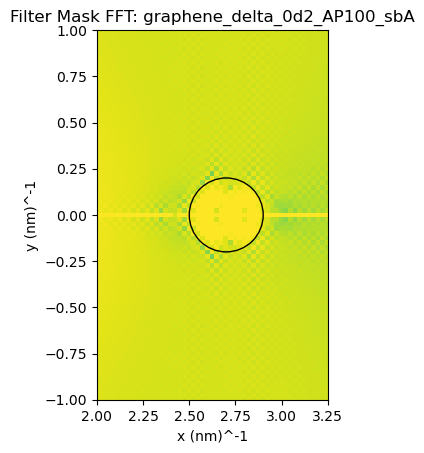

In [22]:
fig5, ax5 = plt.subplots()

ax5.pcolormesh(fxs, fys, plz, vmax=np.mean(plz)/100)

ax5.set_xlabel("x (nm)^-1")
ax5.set_ylabel("y (nm)^-1")
ax5.set_aspect("equal")

ax5.set_xlim(2, 3.25)
ax5.set_ylim(-1, 1)

cradius = 0.2
circle = plt.Circle((2.7, 0), cradius, fill=False)

ax5.set_aspect('equal')

ax5.add_patch(circle)

ax5.set_title("Filter Mask FFT: " + sample_name)

#fig5.savefig("freqout/zoom_filter.png")

In [54]:
# Convert to index value
x1, y1, r1 = 1.36, 2.35, 0.25
x2, y2, r2 = -1.36, -2.35, 0.25

#x1, y1, r1 = 2.7, 0, 0.4
#x2, y2, r2 = -2.7, 0, 0.4

ffx, ffy = np.meshgrid(fxs, fys)

dist = np.sqrt((ffx - x1) ** 2 + (ffy - y1) ** 2)
mask = dist >= r1

dist2 =  np.sqrt((ffx - x2) ** 2 + (ffy - y2) ** 2)
mask2 = dist2 >= r1

plzf = np.where(mask, 0, plz) + np.where(mask2, 0, plz)
ftzf = np.where(mask, 0, ftz) + np.where(mask2, 0, ftz)

(-3.0, 3.0)

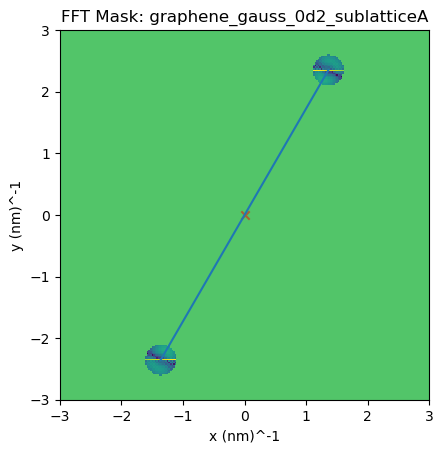

In [55]:
fig6, ax6 = plt.subplots()

ax6.set_xlabel("x (nm)^-1")
ax6.set_ylabel("y (nm)^-1")
ax6.set_aspect("equal")

ax6.pcolormesh(ffx, ffy, plzf)
ax6.set_aspect("equal")

ax6.scatter(0, 0, marker="x", color='red', alpha=0.5)
ax6.plot([x1, x2],[y1, y2])

ax6.set_title("FFT Mask: " + sample_name)

ax6.set_xlim(-3, 3)
ax6.set_ylim(-3, 3)

#fig6.savefig("freqout/mask.png")

In [25]:
#%matplotlib qt

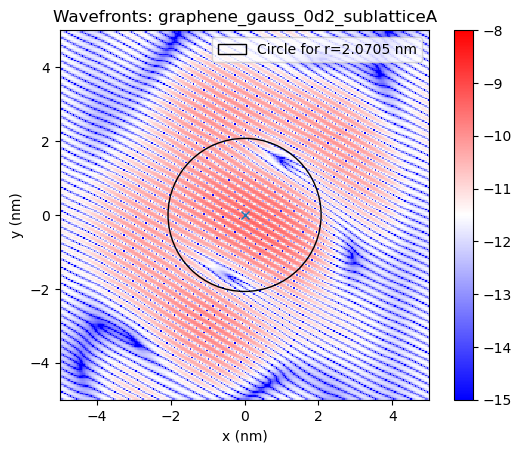

In [74]:
z_filtered = np.fft.ifft2(ftzf)

fig7, ax7 = plt.subplots()

zlog = np.log(np.abs(z_filtered))

c = ax7.pcolormesh(x,y,zlog,vmin=-15, vmax=-8, cmap='bwr')

fig7.colorbar(c, ax=ax7)

#circ = plt.Circle((0, 0), 3.49353451, fill=False)
#ax7.add_patch(circ)

ax7.set_aspect('equal')
ax7.set_xlim(-5, 5)
ax7.set_ylim(-5, 5)
ax7.set_xlabel("x (nm)")
ax7.set_ylabel("y (nm)")

ax7.set_title("Wavefronts: " + sample_name)


cr = 2.0705#nm

circle = plt.Circle((0, 0), cr, fill=False)
ax7.add_patch(circle)

ax7.legend([f"Circle for r={cr:.4f} nm"])

ax7.plot(0, 0, marker="x")

#ax7.set_xlim(-2, 2)
#ax7.set_ylim(-2, 2)

plt.show()

#fig7.savefig("freqout/wavefronts.png")

### Trying to fit lines

Text(0.5, 1.0, 'Wavefronts: graphene_gauss_0d2_sublatticeA')

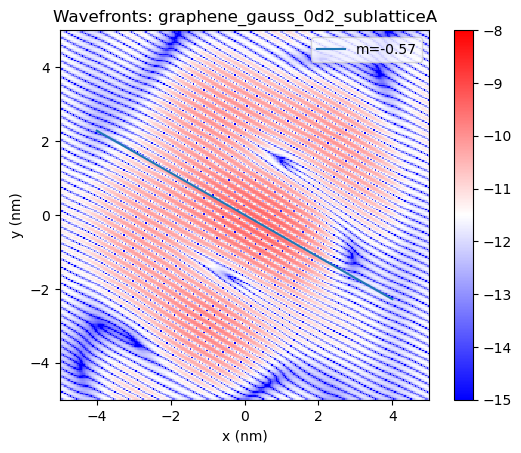

In [104]:
fig8, ax8 = plt.subplots()

c = ax8.pcolormesh(x,y,zlog,vmin=-15, vmax=-8, cmap='bwr')

fig8.colorbar(c, ax=ax8)

ax8.set_aspect('equal')
ax8.set_xlim(-5, 5)
ax8.set_ylim(-5, 5)
ax8.set_xlabel("x (nm)")
ax8.set_ylabel("y (nm)")

m1, b1 = -0.57, 0
xlin = np.linspace(-4, 4)
ax8.plot(xlin, m1 * xlin + b1)
ax8.legend([f'm={m1:.2f}'])

ax8.set_title("Wavefronts: " + sample_name)